In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math
import scipy.stats as sts
import copy
from decimal import *
from sklearn.datasets import load_iris
from scipy.optimize import minimize
from scipy.special import expit
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.metrics.pairwise import (linear_kernel, rbf_kernel, polynomial_kernel, sigmoid_kernel, laplacian_kernel)
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils.validation import check_X_y

In [2]:
def plotData(x, y):
    # Plot the data
    classA = x[y == 1]
    classB = x[y == 0]
    plt.xlabel('X Axis (No units)')
    plt.ylabel('Y Axis (No units)')
    plt.plot(classA[:,0], classA[:,1], 'bo')
    plt.plot(classB[:,0], classB[:,1], 'ro')
    plt.legend(["Class A","Class B"])
    plt.show()

In [3]:
# x_tr: feature vectors of training dataset
# t_tr: labels of training dataset
# x_tst: grid of feature vectors for drawing classes' areas
# t_tst: results of classification of the grid
# x_sv: support vectors
def plotClassification(x_tr, t_tr, x_tst, t_tst, x_sv):   
    #First we plot the training points
    classA_tr = x_tr[t_tr == 1]
    classB_tr = x_tr[t_tr == 0]
    
    plt.plot(classA_tr[:,0], classA_tr[:,1], 'bo')
    plt.plot(classB_tr[:,0], classB_tr[:,1], 'ro')
      
    #Then, we plot the support vectors
    plt.plot(x_sv[:,0], x_sv[:,1] , 'go', markersize = 15, mfc = "None") 
    
    plt.legend(["Class A","Class B", "Support Vectors"])
    
    #Finally, we plot the test results
    classA_tst = x_tst[t_tst == 1]
    classB_tst = x_tst[t_tst == 0]
    
    plt.xlabel('X Axis (No units)')
    plt.ylabel('Y Axis (No units)')

    plt.plot(classA_tst[:,0], classA_tst[:,1], 'bs', alpha=0.05)
    plt.plot(classB_tst[:,0], classB_tst[:,1], 'rs', alpha=0.05)
    #plt.savefig('test.pdf', bbox_inches='tight')
    plt.show()

In [4]:
def kernel_1(X1, X2, kernelParams):
    return laplacian_kernel(X1, X2, kernelParams[0])

In [5]:
iris = load_iris()
#data_check, targ_check = check_X_y(iris.data, iris.target)
X = []
t = []

for i in range(len(iris.data)):
    if iris.target[i] == 1 or iris.target[i] == 2:
        X.append(iris.data[i][:-2])
        t.append((iris.target[i]-1)) # TODO: Identify unique labels, change to 0/1-format
X = np.array(X)
t = np.array(t)

h = 55
x_0_min = np.min(X[:,0])
x_0_max = np.max(X[:,0])
x_1_min = np.min(X[:,1])
x_1_max = np.max(X[:,1])
xx0, xx1 = np.meshgrid(np.linspace(x_0_min, x_0_max, num=h),
                         np.linspace(x_1_min, x_1_max, num=h))
X_tst = np.vstack((xx0.reshape(1,-1),xx1.reshape(1,-1))).T

Alphas[i]: 9.99998011068e-07
Alphas[i]: 9.99994843579e-07
Alphas[i]: 9.99993457277e-07
Alphas[i]: 9.99999794899e-07
Alphas[i]: 9.9999992178e-07
Alphas[i]: 9.99999812062e-07
Alphas[i]: 9.99995487718e-07
Alphas[i]: 9.99999481692e-07
Alphas[i]: 9.99999507751e-07
Alphas[i]: 9.99999720928e-07
Alphas[i]: 9.99999721118e-07
Alphas[i]: 9.99998761309e-07
Alphas[i]: 9.99993028351e-07
Alphas[i]: 9.99999723375e-07
Alphas[i]: 9.99999852935e-07
Alphas[i]: 9.99996872574e-07
Alphas[i]: 9.99999926684e-07
Alphas[i]: 9.99998852962e-07
Alphas[i]: 9.99999742486e-07
Alphas[i]: 9.99999884606e-07
Alphas[i]: 9.99999767704e-07
Alphas[i]: 9.99999719489e-07
Alphas[i]: 9.99997848706e-07
Alphas[i]: 9.99999719489e-07
Alphas[i]: 9.99999808563e-07
Alphas[i]: 9.99998851233e-07
Alphas[i]: 9.99999463181e-07
Alphas[i]: 9.99999334773e-07
Alphas[i]: 9.99999168234e-07
Alphas[i]: 9.99999579825e-07
Alphas[i]: 9.99999919529e-07
Alphas[i]: 9.99999919529e-07
Alphas[i]: 9.99998852962e-07
Alphas[i]: 9.99999915066e-07
Alphas[i]: 9.99

Alphas[i]: 9.99991394884e-07
Alphas[i]: 9.99998877957e-07
Alphas[i]: 9.99999234252e-07
Alphas[i]: 9.99995404949e-07
Alphas[i]: 9.99997852726e-07
Alphas[i]: 9.999973391e-07
Alphas[i]: 9.99996672942e-07
Alphas[i]: 9.99998319299e-07
Alphas[i]: 9.99999678114e-07
Alphas[i]: 9.99999678114e-07
Alphas[i]: 9.99995411858e-07
Alphas[i]: 9.99999660264e-07
Alphas[i]: 9.99998879964e-07
Alphas[i]: 9.99999647347e-07
Alphas[i]: 9.99987490409e-07
Alphas[i]: 9.99999292231e-07
Alphas[i]: 9.99999706736e-07
Alphas[i]: 9.99999894697e-07
Alphas[i]: 9.99999719042e-07
Alphas[i]: 9.99995821494e-07
Alphas[i]: 9.99998141411e-07
Alphas[i]: 9.99999136854e-07
Alphas[i]: 9.9999618548e-07
Alphas[i]: 9.9999986144e-07
Alphas[i]: 9.999998158e-07
Alphas[i]: 9.99998556308e-07
Alphas[i]: 9.99998330576e-07
Alphas[i]: 9.9999924825e-07
Alphas[i]: 9.99981951107e-07
Alphas[i]: 9.99995411857e-07
Alphas[i]: 9.99996699122e-07
Alphas[i]: 9.99998568135e-07
Alphas[i]: 9.9999922934e-07
Alphas[i]: 9.99997838903e-07
Alphas[i]: 9.999997758

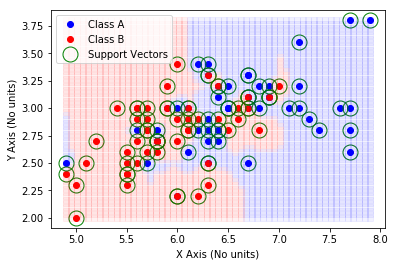

In [43]:
kernel_1_params = [7.6]
X_res, alphas_res, w_res, Phi_res = RVM_C(X, t, kernel_1, kernel_1_params, max_iter_num = 10000, opt_max_iter = 100)
print("X_res:")
print(X_res)
prediction = predict(X_tst, X_res, w_res, kernel_1, kernel_1_params)
plotClassification(X, t, X_tst, prediction, X_res)

In [20]:
# This function filters out infinite alpha values and the columns of the design
# matrix that correspond to them
def filterOutInf(alphaVec,designMatrix,threshHold):
    nonInfIdx = np.where(alphaVec < threshHold)[0]
    filteredAlphaVec = alphaVec[nonInfIdx]
    filteredDesignMatrix = designMatrix[:,nonInfIdx]
    return filteredAlphaVec, filteredDesignMatrix

def getqiAndsi(designMatrix, alphaVec, C,t,postCov,threshHold,index):
    phiI = designMatrix[:,index]
    alphaI = alphaVec[index]
    Cinv = np.linalg.inv(C) 

    temp = np.dot(phiI.T,Cinv)

    Qi = np.dot(temp,t)

    Si = np.dot(temp,phiI)

    if alphaI >= threshHold:
        qi = Qi
        si = Si
    else:
        qi = alphaI*Qi/(alphaI-Si)
        si = alphaI*Si/(alphaI-Si)

    return qi, si

def getC(alphaVec,designMatrix,postMean):
    y = expit(np.dot(designMatrix, postMean))
    B = np.diag(y * (1 - y))
    A = np.diag(alphaVec)
    return B + np.dot(np.dot(designMatrix,A),designMatrix.T)
    
def updateAlphaValue(designMatrix,alphaVec,postMean,t,postCov,threshHold, index):
    C = getC(alphaVec,designMatrix,postMean)
    qi, si = getqiAndsi(designMatrix, alphaVec, C, t,postCov, threshHold,index)
    if qi**2 > si:
        return si**2/(qi**2-si)
    else:
        return math.inf


In [42]:
# X: training feature vectors
# t: training labels
# kernel: function of the form "kernel(X1, X2, kernel_params)"
# kern_params: params for the passed kernel function
# returns: 
def RVM_C(X, t, kernel, kern_params, max_iter_num = 1000, opt_max_iter = 100, tolerance = 1e-7, alpha_threshold = 1e7):

    N = len(t)
    Phi = kernel(X, X, kern_params) #rbf_kernel(X, X, kern_param)
    Phi = np.append(Phi, np.ones((N, 1)), axis = 1)
    Phi_t = Phi.T
    opt_options = { 'maxiter': opt_max_iter }
    biasFlag = True
    numLessTol = 0

    numRelevant = N+1
    alphas = np.full(numRelevant, 1e-6)
    w_mode = np.zeros(numRelevant)

    alphas_res = None
    Phi_res = None
    w_res = None
    X_res = copy.deepcopy(X)

    for iterNum in range(max_iter_num):
        opt_res = minimize(fun=getLogPosterior, x0=w_mode, hess=getHessian, method='Newton-CG', \
                           args=(alphas, Phi, Phi_t, t), jac=True, options=opt_options)

        w_mode = opt_res.x
        Sigma = np.linalg.inv(getHessian(w_mode, alphas, Phi, Phi_t, t))

        # Prune basis functions

        basisInds = []
        sumDiff = 0
        for i in range(numRelevant):
            alpha_prev = alphas[i]
            
            alphas[i] = (1 - Sigma[i][i]*alpha_prev)/(w_mode[i]*w_mode[i])
            if (alphas[i] < alpha_threshold):
                basisInds.append(i)
                sumDiff += np.fabs(alphas[i]-alpha_prev)

        if (sumDiff < tolerance):
            numLessTol += 1
        if (numLessTol > 3):
            # Save results
            
            print(alphas) ###

            numRelevant = len(basisInds)

            alphas_res = np.zeros(numRelevant)
            Phi_res = np.zeros((N, numRelevant))
            w_res = np.zeros(numRelevant)
            X_new = np.zeros((numRelevant, len(X[0]-1)))

            for i in range(numRelevant):
                alphas_res[i] = alphas[basisInds[i]]
                w_res[i] = w_mode[basisInds[i]]
                for j in range(N):
                    Phi_res[j][i] = Phi[j][basisInds[i]]
                if (basisInds[i] != len(X_res)):
                    for j in range(len(X[0])):
                        X_new[i][j] = X_res[basisInds[i]][j]

            X_res = X_new

            break

        if (len(basisInds) == 0):
            basisInds.append(0)
            # First iteration
            if (biasFlag):
                basisInds.append(len(alphas)-1)

        if (biasFlag):
            if not (alphas[-1] < alpha_threshold):
                biasFlag = False

        numRelevant = len(basisInds)

        alphas_new = np.zeros(numRelevant)
        Phi_new = np.zeros((N, numRelevant))
        w_mode_new = np.zeros(numRelevant)
        X_new = np.zeros((numRelevant, len(X[0])))

        for i in range(numRelevant):
            alphas_new[i] = alphas[basisInds[i]]
            w_mode_new[i] = w_mode[basisInds[i]]
            for j in range(N):
                Phi_new[j][i] = Phi[j][basisInds[i]]
            if (basisInds[i] != len(X_res)):
                for j in range(len(X[0])):
                    X_new[i][j] = X_res[basisInds[i]][j]

        alphas = alphas_new
        w_mode = w_mode_new
        Phi = Phi_new
        Phi_t = Phi.T
        X_res = X_new
        
    # X_res: features of the support vectors
    # alphas_res: support vectors alphas
    # w_res: optimal parameters' values
    # Phi_res: Phi's of the support vectors
    return X_res, alphas_res, w_res, Phi_res

def sparse_RVM_C(X, t, kernel, kern_params, max_iter_num = 1000, opt_max_iter = 100, tolerance = 1e-7, alpha_threshold = 1e7):

    N = len(t)
    Phi = kernel(X, X, kern_params) #rbf_kernel(X, X, kern_param)
    Phi = np.append(Phi, np.ones((N, 1)), axis = 1)
    Phi_t = Phi.T
    opt_options = { 'maxiter': opt_max_iter }
    biasFlag = True
    numLessTol = 0

    numRelevant = N+1
    alphas = np.full(numRelevant, 1e-6)
    w_mode = np.zeros(numRelevant)

    alphas_res = None
    Phi_res = None
    w_res = None
    X_res = copy.deepcopy(X)

    for iterNum in range(max_iter_num):
        opt_res = minimize(fun=getLogPosterior, x0=w_mode, hess=getHessian, method='Newton-CG', \
                           args=(alphas, Phi, Phi_t, t), jac=True, options=opt_options)

        w_mode = opt_res.x
        Sigma = np.linalg.inv(getHessian(w_mode, alphas, Phi, Phi_t, t))
        
        
        
        # Prune basis functions

        basisInds = []
        sumDiff = 0
        for i in range(numRelevant):
            alpha_prev = alphas[i]
            
            alphas[i] = updateAlphaValue(Phi,alphas,w_mode,t,Sigma,alpha_threshold, i)
            print("Alphas[i]: "+str(alphas[i]))
            if (alphas[i] < alpha_threshold):
                basisInds.append(i)
                sumDiff += np.fabs(alphas[i]-alpha_prev)

        if (sumDiff < tolerance):
            numLessTol += 1
        if (numLessTol > 3):
            # Save results
            
            #print(alphas) ###

            numRelevant = len(basisInds)

            alphas_res = np.zeros(numRelevant)
            Phi_res = np.zeros((N, numRelevant))
            w_res = np.zeros(numRelevant)
            X_new = np.zeros((numRelevant, len(X[0])))

            for i in range(numRelevant):
                alphas_res[i] = alphas[basisInds[i]]
                w_res[i] = w_mode[basisInds[i]]
                for j in range(N):
                    Phi_res[j][i] = Phi[j][basisInds[i]]
                if (basisInds[i] != len(X_res)):
                    for j in range(len(X[0])):
                        X_new[i][j] = X_res[basisInds[i]][j]

            X_res = X_new

            break

        if (len(basisInds) == 0):
            basisInds.append(0)
            # First iteration
            if (biasFlag):
                basisInds.append(len(alphas)-1)

        if (biasFlag):
            if not (alphas[-1] < alpha_threshold):
                biasFlag = False

        numRelevant = len(basisInds)

        alphas_new = np.zeros(numRelevant)
        Phi_new = np.zeros((N, numRelevant))
        w_mode_new = np.zeros(numRelevant)
        X_new = np.zeros((numRelevant, len(X[0])))

        for i in range(numRelevant):
            alphas_new[i] = alphas[basisInds[i]]
            w_mode_new[i] = w_mode[basisInds[i]]
            for j in range(N):
                Phi_new[j][i] = Phi[j][basisInds[i]]
            if (basisInds[i] != len(X_res)):
                for j in range(len(X[0])):
                    X_new[i][j] = X_res[basisInds[i]][j]

        alphas = alphas_new
        w_mode = w_mode_new
        Phi = Phi_new
        Phi_t = Phi.T
        X_res = X_new
        
    # X_res: features of the support vectors
    # alphas_res: support vectors alphas
    # w_res: optimal parameters' values
    # Phi_res: Phi's of the support vectors
    print("Alphas:")
    print(alphas_res)
    return X_res[:-1], alphas_res, w_res[:-1], Phi_res

In [7]:
def getLogPosterior(w, alphas, Phi, Phi_t, t):
    # Return the objective's value at w
    y = expit(np.dot(Phi, w))
    res = 0
    for i in range(len(t)):
        if (t[i] == 1):
            res += np.log(y[i])
            continue
        res += np.log(1-y[i])
    diagAlphas = np.diag(alphas)
    res -= 0.5 * np.dot(w.T, np.dot(diagAlphas, w)) #Decimal(0.5)*(np.dot(np.dot(w.T, A), w))
    func_prime = np.dot(np.diag(alphas), w) - np.dot(Phi.T, (t-y))
    # Invert for finding maximum
    return -res, func_prime

def getHessian(w, alphas, Phi, Phi_t, t):
    y = expit(np.dot(Phi, w))
    B = np.diag(y * (1 - y))
    # Invert for finding maximum
    return np.diag(alphas) + np.dot(Phi.T, np.dot(B, Phi))

In [8]:
# Get prediction labels
def predict(X_test, X_res, w_res, kernel, kern_params):
    Phi = kernel(X_test, X_res, kern_params)
    y = expit(np.dot(Phi, w_res))
    y = np.column_stack((1-y, y))
    res = np.full(y.shape[0], 0)
    res[y[:, 1] > 0.5] = 1
    return res